# Introduction

In this notebook, we provide an intuitive introduction to the foundations of artificial intelligence.

**Learning outcomes:**
- how biological brains inspired the development of artificial neural networks in the hope of emergent intelligent behaviour in artificial brains;
- how multi-layer perceptrons (MLPs) provide the backbone of all modern neural networks;
- and how MLPs can approximate any function (universal function approximation theorem).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pints.toy import FitzhughNagumoModel
import seaborn as sns
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import kai

sns.set_theme()

# 1 The Perceptron

Intuitively, one might expect artificial intelligence (AI) to arise when detailed models of the human brain are simulated on a computer. This intuition motivated the development of artificial neural networks more than 60 years ago. These artificial neural networks are now at the core of all modern AI models. In this notebook, we will retrace these early developments of artificial intelligence to better understand why language models, such as GPT3, process language the way they do.

The smallest building blocks of brains are brain cells, also known as neurons. Each neuron by itself is not more intelligent than any other cell in our body. But our brains are composed of approximately 100 billion neurons which communicate with each other and process information in a coordinated way. This is widely believed to lead to the emergence of intelligence. A good start for artificial intelligence is therefore to first build a model of a neuron, and then make many of those neurons communicate in the hope to see artificial intelligence emerge in a similar way to biological neural networks.

In the figure below, we illustrate a human neuron in the left panel. The right panel shows a model of the neuron: an artificial neuron, commonly referred to as *perceptron*. The biological neuron consists of a junction of dendrites with the cell nucleus in the middle, and an axon leading away from the neuron. Neurons receive electrical signals through their dendrites and forward strong enough signals to other neurons along their axons. The perceptron emulates this behaviour by receiving $n$ input signals $x_1, \ldots, x_n$ which are processed into one output signal $y$.

<img src="biological-neuron.jpg" width="500" style="display: block; margin: 0 auto" >

More specifically, the perceptron in the figure is defined by a linear combination of the input signals and a step function that only returns a value of $1$ when the weighted sum is greater than zero 

$$
y = f(x, w) = \Theta (w_0\, x_0 + \ldots + w_n\, x_n),
$$
where $\Theta(z) = 1$ for $z>0$, and $\Theta(y) = 0$ otherwise. This activation function, $\Theta(z)$, mimics the behaviour of neurons to only forward signals if the incoming signals are large enough.

### Task 1: Implement a simple artificial neuron

To familiarise yourselfves with how perceptrons process information, implement a perceptron by completing the code block below. When you are ready, use the notebook cell after that to test your implementation.

In [2]:
def perceptron(x):
    """
    Returns the output of a perceptron with 6 input signals.

    Parameters:
        x (List of length 6) Input signals to the perceptron.
    """
    weights = [0.2, -0.3, 0.9, 0.4, -0.9, -0.5]

    # TODO: Calculate y
    z = np.sum(np.array(weights) * np.array(x))

    # Calculate activation
    if z > 0:
        return 1

    return 0

Execute the below cell to chek your implementation.

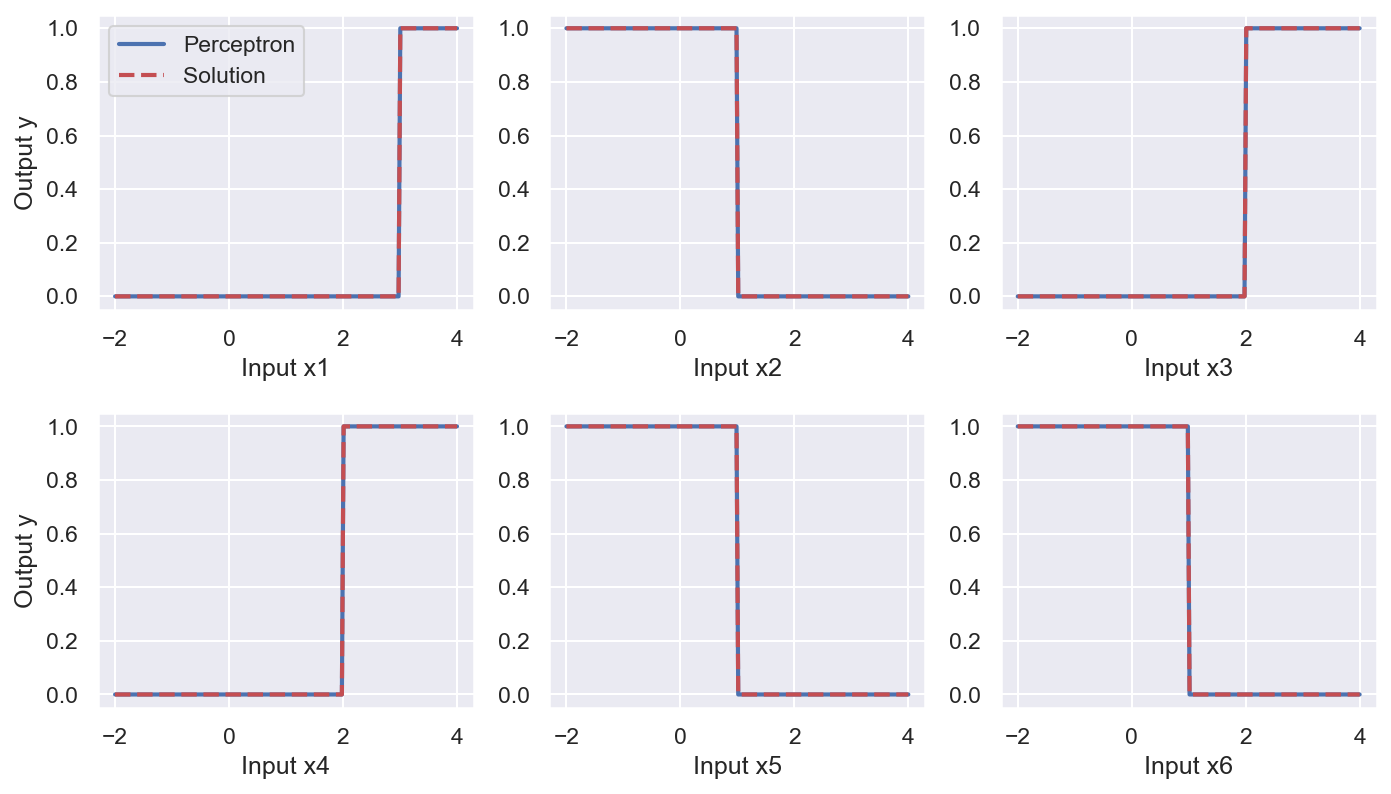

In [3]:
# Solution
kai.plot_perceptron(perceptron)

## 1.1 Example

How can we understand perceptron's processing information in a less abstract way? To this end, let us consider an example, and more specifically, let's say we want to answer the question: "Will Liza go to Emma's party?".

There are certain factors that influence Liza's decision. For instance, if her friend Hannah is going to the party, Liza would not like to go. However, if Kristine is going, Liza would be delighted to attend. If neither of them are going, Liza would like to stay at home.

We can represent this situation using the given setup where the values $w_{1}$ and $w_{2}$ represent the Hannah's and Kristine's influence on Liza's decision, respectively. Negative values are used to denote negative influence (i.e., making Liza less likely to attend the party), while positive values indicate positive impact.

<img src="emmas_party.png" width="500" style="display: block; margin: 0 auto">

When both Hannah and Kristine are going, we can calculate the activation of the model. By using the values $w_{1}= -3$,$w_{1}= 2$ and $w_{1}= -1$, the model outputs an activation of 0. This means that according to the model, Liza will not go to the party.
$$
z = x_{1}w_{1} + x_{2}w_{2} + b = 1(-3) + 1(2) - 1 = -2
a = f(z) = 0
$$

This example demonstrates how the weights and biases can be tuned to make decisions based on inputs. The right combination of weights and biases can help the model make accurate predictions based on the given inputs.

# 2 From single perceptrons to networks of perceptrons

Single perceptrons are mathematically equivalent to linear regression models, if we omit the activation function (in the above example this was the step function, $\Theta(z)$)
$$
    z = \sum _{j=1}^n w_j x_j.
$$
Linear regression models have been used in the machine learning community for a long time and they can help us interpret how perceptrons process information. For example,for just two inputs, we can visualise the output of a perceptron using a straight line in a plane, see below. Note that it is convential to consider $x_0$ to be fixed to one, $x_0=1$. This enables translations of the lines in the plane. The corresponding weight, $w_0$, is commonly referred to as the bias of the perceptron (represented by the constant value in the figure). 

<img src="linear_classifier.png" width="500" style="display: block; margin: 0 auto">

The interpretation of perceptrons as binary linear regressors, i.e. linear classifiers, makes intuitively clear how the smallest building blocks of artificial neural networks process information. But one perceptron alone is limited in what it can do and certainly does not achieve artificial "intelligence".

To visualise the limitations of a single perceptron, let us attempt a simple 2-dimensional classification task using the perceptron.

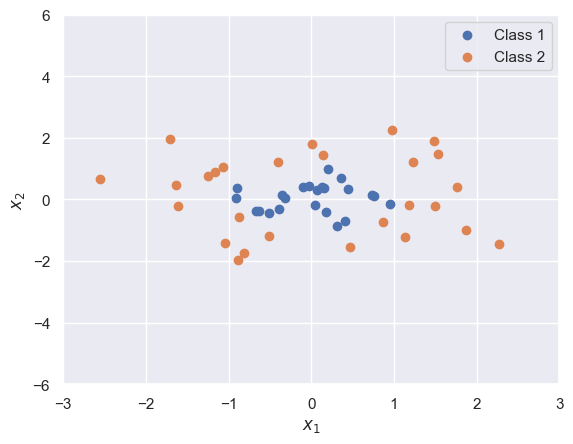

In [4]:
# Generate random data
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1

# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1], label='Class 1')
plt.scatter(X[y==1, 0], X[y==1, 1], label='Class 2')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.xlabel(r'$x_1$')
plt.ylabel(r'$x_2$')
plt.legend()
plt.show()

Here, the task for the perceptron is to classify the points based on the $x_1$ and $x_2$ coordinates. It is clear that we will not be able to use just a single line to separate the blue dots from the orange dots. But, we could, perhaps, use 4 perceptrons to classify the data...

### Task 2: Find 4 perceptrons that can jointly classify the data points
For example, you could decide that a data point is classified as "blue" if all perceptrons return a 1. Otherwise the data point is classified as orange. You can use the below code block to define the weights of the perceptrons, and the code block after that to visualise their decision boundaries.

In [5]:
# TODO
perceptron1 = {
    'bias': -2,
    'weight1': 2,
    'weight2': 1
}
perceptron2 = {
    'bias': -2,
    'weight1': -1,
    'weight2': 2
}
perceptron3 = {
    'bias': -2,
    'weight1': -2,
    'weight2': -1
}
perceptron4 = {
    'bias': -3,
    'weight1': 2,
    'weight2': -2
}

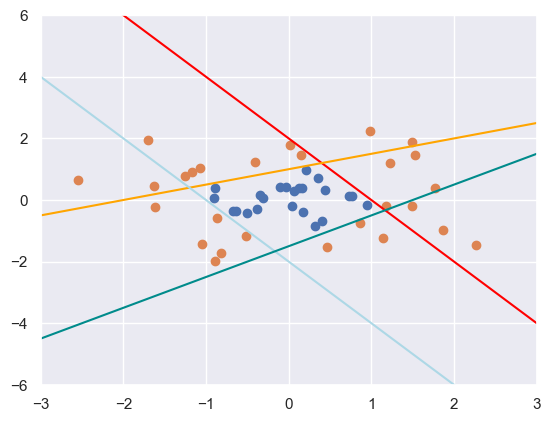

In [6]:
# Plot the data
plt.scatter(X[y==0, 0], X[y==0, 1])
plt.scatter(X[y==1, 0], X[y==1, 1])

# linear classifications
x1 = np.linspace(-3, 3, 100)
x2 = -(perceptron1['weight1'] * x1 + perceptron1['bias']) / perceptron1['weight2']
plt.plot(x1, x2, linestyle='-', color='red')

x2 = -(perceptron2['weight1'] * x1 + perceptron2['bias']) / perceptron2['weight2']
plt.plot(x1, x2, linestyle='-', color='orange')

x2 = -perceptron3['weight1'] / perceptron3['weight2'] * x1 - perceptron3['bias'] / perceptron3['weight2']
plt.plot(x1, x2, linestyle='-', color='lightblue')

x2 = -perceptron4['weight1'] / perceptron4['weight2'] * x1 - perceptron4['bias'] / perceptron4['weight2']
plt.plot(x1, x2, linestyle='-', color='darkcyan')

plt.xlim(-3, 3)
plt.ylim(-6, 6)
plt.show()

This exercise demonstrates that networks of artificial neurons can perform more complex tasks than single perceptrons. The figure below illustrates this network diagrammatically.

<img src="complex_classifier_perceptron_diagram.png" width="1000" style="display: block; margin: 0 auto">

However, so far our neural network does not feel very "intelligent". It can only classify points in a plane, and we had to painfully tweak the weights of the network to do it. More complex networks are able to perform more complex tasks (modern neural networks, such as large language models, have up to 200 billion model weights), but we need to find a way to avoid manually tweaking the weights of network networks.

## 3 Training neural networks

The automatic tweaking of neural network weights is achieved using numerical optimisation algorithms and is referred to as "training" or as "learning" in the AI community. While "training" and "learning" sounds fancy, the high level concept of automatically tweaking network weights to optimise an objective is quite intuitive...

### Task 3: Discuss in your group how you would design an iterative 3-step algorithm that can optimise neural network weights

Complete the below algorithm:

For iteration in range(n_iterations):

1. Do ... Propose weights

2. Do ... Evaluate objective

3. Do ... Accept or reject weights


Did you come across any numerical optimisers before?

A simple, though not very efficient way to train neural networks is to repeatedly sample random weights from a distribution of possible model weights and test whether any of them satisfy our objective using an objective function. In this case, the objective is to classify all points in the dataset correctly. So, the network should assign blue points with the class label "0" and orange points with the class label "1". A simple metric to quantify how well our network does this is to simply count the number of points that the network classifies incorrectly for a given set of model weights

$$
\text{Loss}(w) = \sum _{i=1}^n y_i(1-f(x_i, w)) + \sum _{i=1}^n (1 - y_i)f(x_i, w).
$$

The loss function is used to measure how well the model's predictions match the actual labels in the dataset. 
The objective is to minimize this loss function, which means finding the set of model weights that makes the most accurate predictions.

Here's a more intuitive breakdown of the equation:
- $n$: the number of data points in the dataset
- $y$: the actual class labels (either 0 or 1) for each data point
- $f(x_i, w)$: the predicted class label (either 0 or 1) for the $i$-th data point, given the model weights $w$.
- The two sums in the equation calculate the error for each data point in the dataset.
- The first sum computes the error when the actual label is 1 but the model predicted it to be 0 (i.e. $f(x_i, w)=0$, so $1-f(x_i, w)=1$). In that case, the product of $y_i$ being 1 and $1-f(x_i, w)=1$ would count it as an error.
- The first sum computes the error when the actual label is 0 but the model predicted it to be 1 (i.e. $f(x_i, w)=1$). In that case, the product of $1-y_i$ being 1 and $f(x_i, w)=1$ would count it as an error.
- The combined loss is the sum of these individual errors for all data points in the dataset. The goal is to minimize this loss over all possible sets of model weights, which can be achieved using various optimization algorithms such as stochastic gradient descent.

The optimisation algorithm would then repeatedly: 
1. sample model parameters; 
2. evaluate the objective function / loss for those model parameters; and 
3. accept the model parameters if the loss is lower than before. 

Let us test how well this stochastic optimisation algorithm does!

### Task 4: Implement the objective function / loss function
You can use the implementation of the neural network from the KAI package. Use the pre-implemented checks to test your solution. 

In [7]:
# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1

def loss_function(weights):
    y_pred = kai.neural_network(inputs=X.T, weights=weights)

    # TODO Complete the implementation of the loss function
    mask0 = y == 0
    mask1 = y == 1

    loss = np.sum(1 - y_pred[mask1]) + np.sum(y_pred[mask0])

    return loss


Test your implementation:

In [8]:
weights = np.array([-2, 2, 1, -2, -1, 2, -2, -2, -1, -3, 2, -2])
assert loss_function(weights) == 0

weights += 1
assert loss_function(weights) == 15

weights -= 2
assert loss_function(weights) == 11

### Task 5: Train our neural network so it "learns" how to classify the points by itself

The cell below implements the optimisation algortihm that we have discussed, using the loss function. Execute it to train the model. 

The code will produce plots to visualise the training: 1. the evolution of the loss over the iterations of the optimisation; and 2. the final classification, learned by the neural network. Do the results make sense to you?

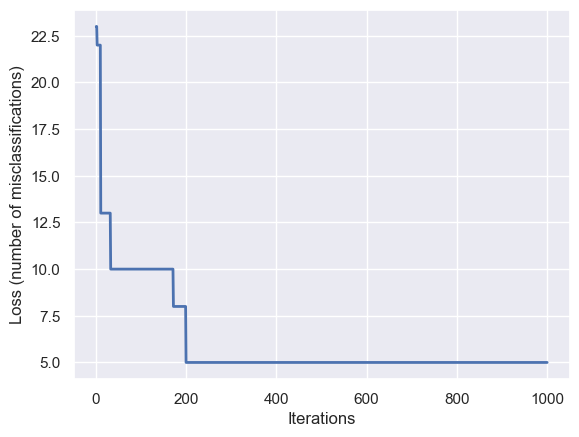

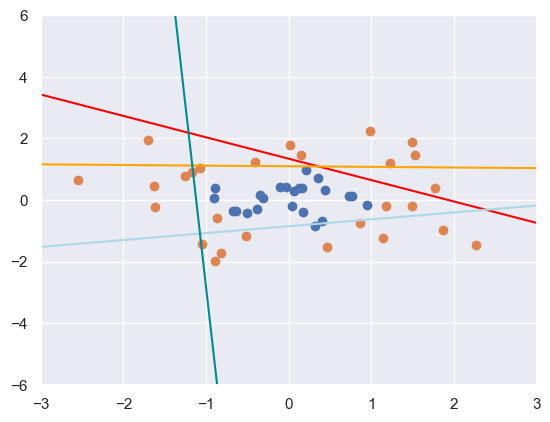

In [9]:
# Training
np.random.seed(1)#42)
n_iterations = 1000
losses = np.empty(n_iterations)
for n in range(n_iterations):
    # Sample proposal
    proposal = np.random.uniform(low=-3, high=3, size=12)
    loss = loss_function(proposal)

    # Accept on first iteration
    if n == 0:
        weights = proposal
        losses[n] = loss
        continue

    # Check whether loss is lower than for previous parameters
    isProposalAccepted = loss < losses[n-1]
    if isProposalAccepted:
        weights = proposal
        losses[n] = loss
    else:
        # We did not accept, so loss remains the same
        losses[n] = losses[n-1]

kai.plot_training_results(n_iterations, losses, weights, (X, y))

That is amazing! Our neural network learned to classify most of the data points all by itself! Why do you think did it not manage to classify all points perfectly?

# 4 Other activation functions for better training

In the above example, we trained a neural network using a simple optimisation algorithm that randomly samples weights from a distribution. This optimiser is guaranteed to evenutally find the optimal set of model parameters for our objective, the only problem is that it can take a veeeery large number of iterations to randomly sample this set of model parameters from the distribution. 

In practice, it is more common to update the neural network weights and biases more systematically. We do this by first randomly assigning weights and biases to the neural network. Why? Because we don't know where else to start. Our goal is to improve the parameters with each iteration, as we did before, but in a more systematic way.
How? We run the network on each training example, compare the output and the desired output, and adjust the weights to minimise the error using the derivatives of the
objective function.

We want to find the weights and biases of the entire network, i.e. the parameters of the network. Starting from a random value, we need to see what the impact of changing a particular parameter is (e.g. $w_{1,1}$). We want a change in a parameter to lead to a change in the activation towards the desired activation.

This is where we encounter our first problem with perceptrons: their activation function is a step function.

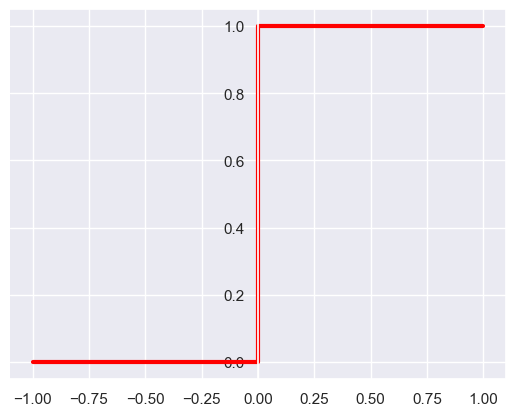

In [10]:
x = [-1, 0, 1]
y = [0, 0, 1]

fig, ax = plt.subplots()
ax.step(x, y, color='red', linewidth=3)

# Move the y-axis ticks to the center
ax.spines['left'].set_position('center')
plt.show()

### Task 6: Given we want to improve our weights in a systematic way, why is the step function a bad activation function for finding weights? (Discuss in your group).

*Hint: How does the output of the activation function change for different inputs? And what does that mean for the gradients of the loss function?*

When you are ready, execute the cell below for a visualisation of what is happening.

### Task 7: Execute the cell below and use the slider in the figure to visualise how the step function changes.

In [11]:
kai.plot_step_activation()

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=0.5, min=-0.15, step=0.01), Output()),…

Say we change $w_1$ by $\Delta w_1$, which will change $z$, which will impact $a = f(z)$. 
If we move the slider to the left, $z$ changes (red dot moves left), but the activation $a$ does not change: it was 0 before, but because $z < 0$, it remains unchanged at 0.
If we move the slider slightly to the right, $a$ does not change either.
We changed $w_1$ (and therefore $z$) in both ways and learned nothing about the impact of $w_1$.
If you move the slider further to the right, all of a sudden $z > 0$ and $a = 1$.
With the step function as the activation function, it's difficult to figure out how to adjust the weights and biases to get the desired activation/output.
There is a lack of change or the sudden change in the output with a small change in the parameters.
This is even more the case with a network of perceptrons.

Since the step function is difficult to work with, we want to work with smoother functions, like the sigmoid function.

*Aside: A mathematically more precise version of what we said above is: the gradient of the step function is 0 everywhere (except at 0, where it is infinite!), see right panel of the figure.*

### 4.1 The sigmoid activation function

To avoid this problem (referred to as "vanishing gradients"), it is common to use other activation functions to improve the learning of neural networks. One of those activation functions is the sigmoid activation function illustrated below.

In [12]:
kai.plot_sigmoid_activation()

interactive(children=(FloatSlider(value=0.0, description='delta_z', max=15.0, min=-7.0), Output()), _dom_class…

The sigmoid activation function is almost the same as the step activation function that we have used before, the only differences is that the change from an output equal to 0 to an output equal to 1 now happens smoothly (avoiding the vashing gradients). Formally, the sigmoid activation can be written as

$$
a = \sigma (z) = \frac{1}{1 + e^{-z}}.
$$

In modern neural networks, many other activation functions are also used. Below we just show a random selection of these activation functions.

$$
\tanh(x) = \frac{e^{x} - e^{-x}}{e^{x} + e^{-x}}
$$
$$
\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x)
$$
$$
\text{Swish}(x) = x \cdot \frac{1}{1 + e^{-\beta x}}
$$
$$
\text{ELU}(x) = \begin{cases} x, & \text{if } x > 0 \\ \alpha (e^x - 1), & \text{otherwise} \end{cases}
$$

Most importantly, they are all smooth, allowing a change in weights to result in a change in the activation, which allows us to systematically find neural network weights and biases (also called model parameters) that optimise the objective function using numerical optimisation algorithms, such as the gradient descent (GD) optimiser. A discussion of the GD optimiser is beyond the scope of today's workshop, but we will develop an inttuition for how it works by using it on different use cases.

### Task 8: Train the neural network again using the GD algorithm

Below, we have prepared an implementation of our neural networks using PyTorch (one of the most popular deep learning frameworks in Python). Execute the cell, and compare the result obtained with the GD optimiser to the previously obtained classifier.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, n_inputs=2, n_perceptrons=4):
        super(NeuralNetwork, self).__init__()
        self.layer = nn.Linear(n_inputs, n_perceptrons, dtype=torch.float64)

    def forward(self, x):
        # Perceptron activation (now using sigmoid)
        out = F.sigmoid(self.layer(x))

        # Joint decision of perceptrons
        out = torch.sum(out, axis=1)
        y = F.sigmoid(out)

        # A little hacky: y is now between 0.5 and 1. Recenter to 0 to 1
        y = (y - 0.5) * 2

        return y

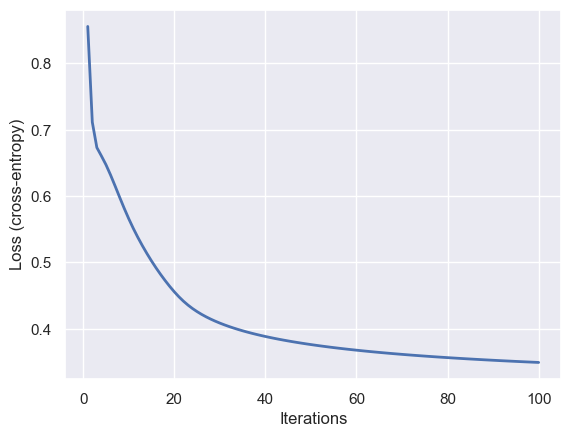

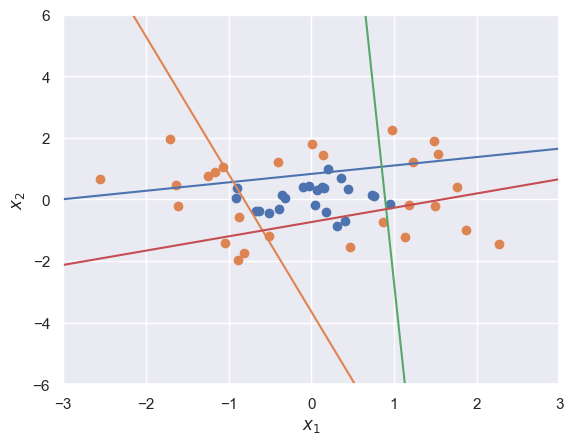

In [14]:
# Set up optimisation
torch.manual_seed(8)
model = NeuralNetwork()
objective_function = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr=10)

# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1
inputs = torch.tensor(X)
labels = torch.tensor(y)

# Run optimisation
losses = []
n_iterations = 100
for epoch in range(n_iterations):
    # Reset the parameter gradients
    optimiser.zero_grad()

    # Simulation, evaluation and parameter proposal
    outputs = model(inputs)
    loss = objective_function(outputs, labels)
    loss.backward()
    optimiser.step()

    losses.append(loss.detach().numpy())

kai.plot_results2(n_iterations, losses, model, (X, y))

Number of incorrectly classified points:

In [15]:
mask0 = y == 0
mask1 = y == 1
y_pred = model(inputs).detach().numpy()
n_misclassified = np.sum(1 - np.round(y_pred[mask1])) + np.sum(np.round(y_pred[mask0]))
n_misclassified

6.0

The GD optimiser finds a good set of network weights much faster than the stochastic optimiser, but it still fails to find the optimal arrangement of the decision boundaries -- even if we run the optimiser for many more iterations (try it!).

One way to improve the performance of the network is to add more perceptrons to it. 

*(For the maths nerds among you: This creates more local minima which are able to classify the data points perfectly.)*

### Task 9: Retrain the network with more perceptrons

Amend the network below, so that it uses 10 perceptrons for the classification instead of 4.

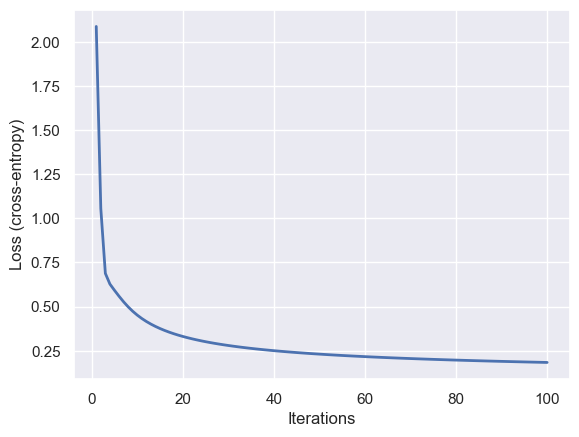

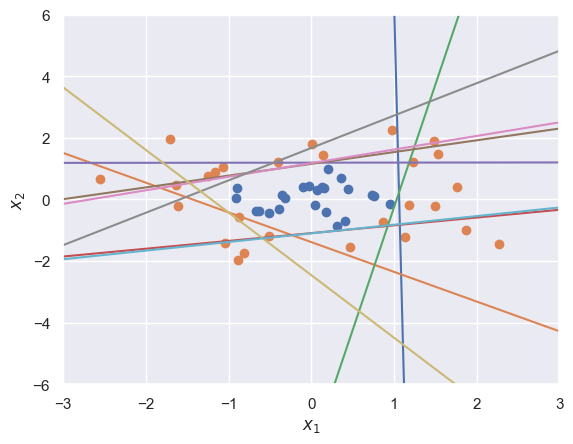

In [16]:
# TODO: Set the number of perceptrons and execute the cell
n_perceptrons = 10

# Set up optimisation
torch.manual_seed(8)
model = NeuralNetwork(n_perceptrons=n_perceptrons)
objective_function = nn.BCELoss()
optimiser = optim.SGD(model.parameters(), lr=10)

# We regenerate the data, just in case X was overwritten
np.random.seed(0)
n_samples = 50
X = np.random.randn(n_samples, 2)
y = np.zeros(n_samples)
y[np.linalg.norm(X, axis=1) > 1] = 1
inputs = torch.tensor(X)
labels = torch.tensor(y)

# Run optimisation
losses = []
n_iterations = 100
for epoch in range(n_iterations):
    # Reset the parameter gradients
    optimiser.zero_grad()

    # Simulation, evaluation and parameter proposal
    outputs = model(inputs)
    loss = objective_function(outputs, labels)
    loss.backward()
    optimiser.step()

    losses.append(loss.detach().numpy())

kai.plot_results2(n_iterations, losses, model, (X, y))

Number of incorrectly classified points:

In [17]:
mask0 = y == 0
mask1 = y == 1
y_pred = model(inputs).detach().numpy()
n_misclassified = np.sum(1 - np.round(y_pred[mask1])) + np.sum(np.round(y_pred[mask0]))
n_misclassified

1.0

## 5 From single-layer networks to multi-layer networks

So far, when we added more perceptrons to the network, we treated all perceptrons equally, in the sense that all perceptrons process the raw input data and equally contribute to the final output of the neural network. This non-hierarchical use of perceptrons limits which tasks can be achieved by neural networks.

In the final section of this notebook, we will begin to train multi-layer networks, introducing a hierarchy between the perceptrons. More specifically, we focus on a network architecture known as multi-layer perceptron (MLP). 
This MLP is part of almost all modern neural networks used today.

To motivate the use of MLPs, let us try to use our simple multi-perceptron network from above to solve a more complex task: image classification. 
As an example for an image classification task, we use the digit dataset MNIST, which contains a large number of labelled images with digits in them.

### Task 10: Execute the cell below to illustrate some examples from the dataset

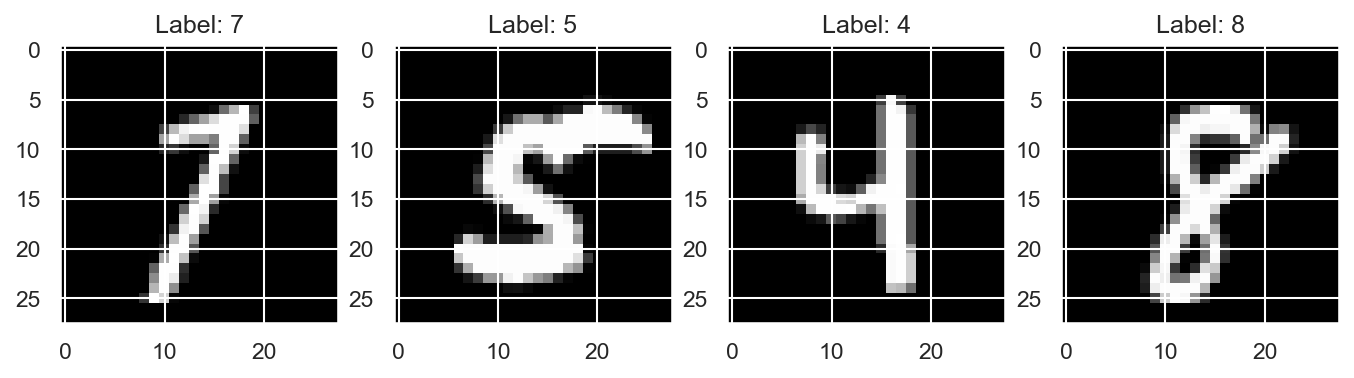

In [18]:
batch_size = 64

# Load Data
train_dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='dataset/', train=False, transform=transforms.ToTensor(), download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)

# Visualise data
images, labels = next(iter(train_loader))
kai.plot_four_images(images, labels)

The data consists of images (32x32 pixels) and corresponding labels. If we want to use our simple network from above to classify the images, we need it to take an image as input (i.e. 32x32 = 784 inputs) and output the class label. However, so far our model only predicts values between 0 and 1, making the mapping of the output to the class labels challenging.

A common way to solve multi-class classification is to use a second layer that takes the inputs from the previous layer and processes them further to output several values -- one value for each class. If those outputs are normalised, they can be interpreted as the model's confidence for the classification.

### Task 11: Amend the single-layer perceptron to have 10 outputs instead of 1

Use the second layer to process the output of the first layer and return 10 outputs. Test you implementation by training the model on the data using the cell below. If you implemented the model correctly, it should achieve a test accuracy of >95%.

In [19]:
class NeuralNetwork2(nn.Module):
    def __init__(self, n_inputs=784, n_perceptrons=64, n_classes=10):
        super(NeuralNetwork2, self).__init__()
        self.layer1 = nn.Linear(n_inputs, n_perceptrons)
        self.layer2 = nn.Linear(n_perceptrons, n_classes)

    def forward(self, x):
        # Perceptron activation (now using sigmoid)
        out = F.relu(self.layer1(x))

        # TODO: Process the output with the second layer
        y = self.layer2(out)

        return y

In [20]:
# Train Network
input_size = 784
num_classes = 10
learning_rate = 0.001
num_epochs = 5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNetwork2(
    n_inputs=input_size, n_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}')

    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device=device)
        targets = targets.to(device=device)

        data = data.reshape(data.shape[0], -1)  # Flatten
        scores = model(data)
        loss = criterion(scores, targets)

        # backward
        optimizer.zero_grad()  # set all gradients to zero for each batch
        loss.backward()

        # gradient descent
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2
Epoch: 3
Epoch: 4


In [21]:
def check_accuracy(loader, model):

    if loader.dataset.train:
        print("Accuracy on training data")
    else:
        print("Accuracy on testing data")

    num_correct = 0
    num_samples = 0
    model.eval()

    with torch.no_grad():  # dont compute gradients
        for x, y in loader:
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0],-1)

            scores = model(x)
            _, predictions = scores.max(1)

            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(f'Got {num_correct}/{num_samples} with accuracy {float(num_correct)/float(num_samples)*100: .2f}')

    model.train()


check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Accuracy on training data
Got 58810/60000 with accuracy  98.02
Accuracy on testing data
Got 9705/10000 with accuracy  97.05


Amazing! You just trained your first MLP and achieved an amazing image classification accuracy of >90% on a test dataset that the model has never seen before! So we really start to see how we can use networks of simple artificial neurons to achieve very complex tasks.

In fact, one can prove that MLPs can lean to solve any task perfectly that can be formulated in terms of an input-output relationship, i.e. a function, and sufficient data is available. Here, the function that we are trying to learn from the data is the probability mass function over the digits conditional on the input image

<img src="Picture_1.png" width="350" style="display: block; margin: 0 auto">
<img src="Picture_2.png" width="350" style="display: block; margin: 0 auto">

For some images, the digit is simple to identify and the model is expected to assign all probability mass to the corresponding digit class. For others, the handwriting might be more difficult to decipher and the probablity should be spread across the class labels more evenly.

*Aside: Formally, the probablity mass function can be denoted by*
$p(y| x) \approx f(y | x, w)$,
*where $y$ denotes the digit and $x$ denotes the image.*


<img src="multi_layer_perceptron_network.avif" width="700" style="display: block; margin: 0 auto">

While MLPs get closer to biological brains, in the sense that they use cascades of neurons to process information, it is certainly a stretch to expect MLPs to display intelligent behaviour. Nevertheless, a remarkable property of MLPs that lead to the brought success of AI in recent years is is that they are **universal function approximators**.

Universal function approximation means that MLPs can perfectly describe any function, provided: 1. we have sufficient data from the function to train the model on; and 2. the MLP has sufficiently many artificial neurons in each layer. In this workshop, we will not go into the details of proving the universal function approximation theorem, but we built on MLPs to develop neural network architectures that can be used for natual language processing.

## Optional: Test the universal function approximation theorem

Below is a mechanistic model of how the conductance in nerve membranes changes upon stimulation. This model was developed by Fitzhugh in 1965 (see https://doi.org/10.1002/jcp.1030660518). The details of the model are not quite trivial, see e.g. https://pints.readthedocs.io/en/latest/toy/fitzhugh_nagumo_model.html. However, using the neural networks as universal function approximators, we can learn this complicated function by only using input-output data points.

Here, the input to the model is the time point at which we want to know the voltage of the nerve membrane, and the voltage is the output.

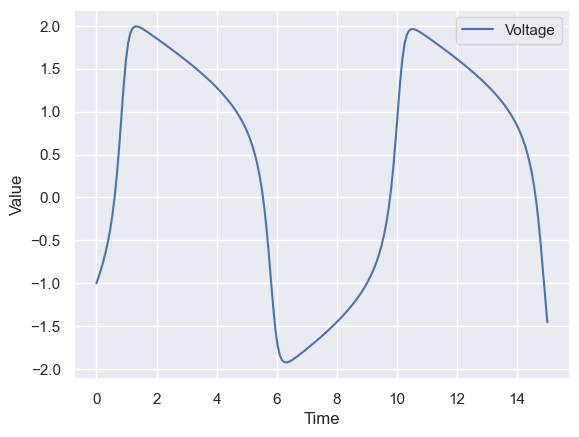

In [2]:
model = FitzhughNagumoModel()
parameters = [0.1, 0.5, 3]
times = np.linspace(0, 15, 200)
voltage = model.simulate(parameters, times)[:, 0]

# Plot simulation
plt.figure()
plt.xlabel('Time')
plt.ylabel('Value')
plt.plot(times, voltage)
plt.legend(['Voltage'])
plt.show()

### Task 12: Use a neural network to model the conductance in nerve membranes

#### Step 1: Define an MLP with 1 input and 1 output
You should use three linear layers (``nn.Linear``). Think about which activations make sense for the network

In [26]:
# TODO: Implement the neural network
class NeuralNetwork3(nn.Module):
    def __init__(self, n_inputs=1, n_perceptrons=200, n_outputs=1):
        super(NeuralNetwork3, self).__init__()
        self.layer1 = nn.Linear(n_inputs, n_perceptrons, dtype=float)
        self.layer2 = nn.Linear(n_perceptrons, n_perceptrons, dtype=float)
        self.layer3 = nn.Linear(n_perceptrons, n_outputs, dtype=float)

    def forward(self, x):
        out = F.leaky_relu(self.layer1(x))
        out = F.leaky_relu(self.layer2(out))
        y = self.layer3(out)

        return y

#### Step 2: Train the neural network on the data
Which objective function makes sense for the training? You can find all pre-implemented objective functions in PyTorch here: https://pytorch.org/docs/stable/nn.html#loss-functions

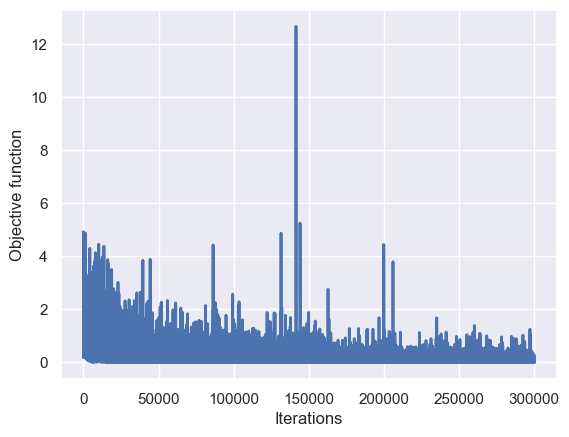

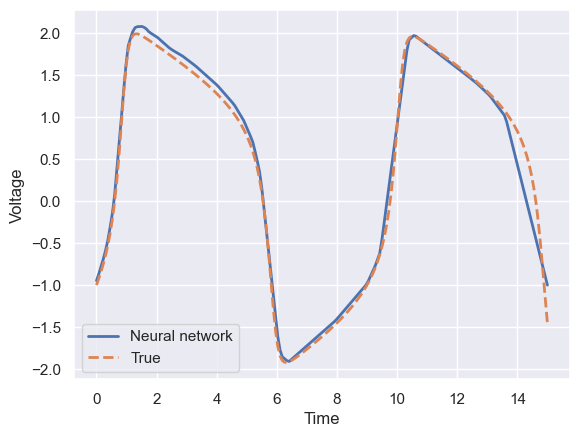

In [34]:
# TODO: Define a suitable objective function
objective_function = nn.MSELoss()

# Set up optimisation
torch.manual_seed(8)
model = NeuralNetwork3()
optimiser = optim.SGD(model.parameters(), lr=0.0005)

# Format data
inputs = torch.tensor(times[:, np.newaxis])
true_outputs = torch.tensor(voltage[:, np.newaxis])
n = len(inputs)

# Run optimisation
n_samples = 5
losses = []
n_iterations = 300000
for epoch in range(n_iterations):
    # Reset the parameter gradients
    optimiser.zero_grad()

    # Take subset of data
    idx = np.random.randint(n, size=n_samples)
    t = inputs[idx]
    o = true_outputs[idx]

    # Simulation, evaluation and parameter proposal
    outputs = model(t)
    loss = objective_function(outputs, o)
    loss.backward()
    optimiser.step()

    losses.append(loss.detach().numpy())

# Plot loss
iterations = np.arange(1, n_iterations+1)
plt.plot(iterations, losses, linewidth=2)
plt.xlabel('Iterations')
plt.ylabel('Objective function')
plt.show()

pred = model(inputs).detach().numpy()[:, 0]
plt.plot(times, pred, linewidth=2, label='Neural network')
plt.plot(times, voltage, linewidth=2, label='True', linestyle='--')
plt.xlabel('Time')
plt.ylabel('Voltage')
plt.legend()
plt.show()